Gig_ITicket_PriceD       2000
Venue_ID                 2000
Show_DateTime            2000
Day_of_Week              2000
Volume_Level             1819
Ticket_Price             2000
Crowd_Size               1960
Opener_Rating            2000
Weather                  2000
Moon_Phase               2000
Band_Outfit              2000
Merch_Sales_Post_Show    2000
Crowd_Energy             2000
Ticket_Price_USD         1954
dtype: int64


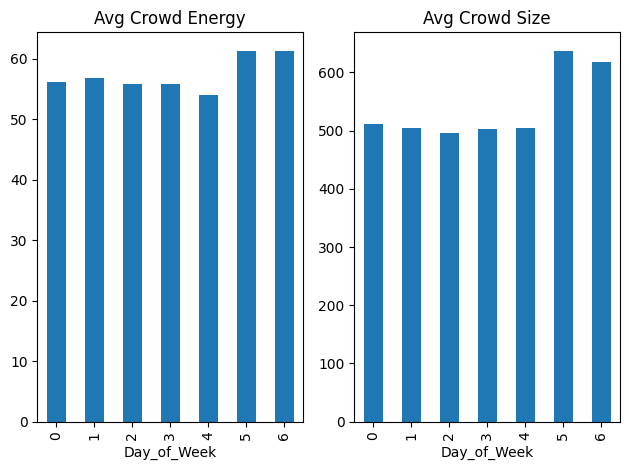

crowd size for tuesday is lesser than mean 


In [8]:
import pandas as pd
import numpy as np

def convert_to_usd(price):
    if pd.isna(price):
        return np.nan

    price = str(price).strip()

    if "free" in price.lower():
        return 0.0
    
    if "vip" in price.lower():
        return np.nan

    price = price.replace("USD", "").replace("usd", "").strip()

    if price.startswith("£"):
        return float(price[1:]) * 1.27
    
    elif price.startswith("€"):
        return float(price[1:]) * 1.09
    elif price.startswith("$"):
        return float(price[1:])
    else:
        return float(price)




def time_of_day(hour):
    if 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    elif hour<=3 or hour >=21 : 
        return "Night"


import matplotlib.pyplot as plt

df = pd.read_csv('tour_logs_train.csv')

# currrency conversion
df["Ticket_Price_USD"] = df["Ticket_Price"].apply(convert_to_usd)
print(df.count())

#date time correction 
df['Show_DateTime'] = pd.to_datetime(
    df['Show_DateTime'],format='mixed',dayfirst=True,errors='coerce')


#filling of missing volume level and crowd size by their mean

venues = ["V_Alpha", "V_Beta", "V_Gamma", "V_Delta"]
cols = ["Crowd_Size", "Volume_Level"]

df.loc[df["Venue_ID"].isin(venues), cols] = (
    df.loc[df["Venue_ID"].isin(venues)]
      .groupby("Venue_ID")[cols]
      .transform(lambda x: x.fillna(x.mean()))
)

df=df.dropna(subset=["Show_DateTime"])




#removing irelavent rows with immposible values
df = df[
    (df['Crowd_Size'] ).between(1,2000) &
    (df['Volume_Level'].between(1, 100)) &
    (df['Day_of_Week']).between(0,6)&
    (df['Crowd_Energy']).between(1,99)&
    (df['Merch_Sales_Post_Show']>=0)&
    (df['Opener_Rating'].between(1,5))
#    (df['Ticket_Price'] >=0)
]

Alpha = df[df["Venue_ID"]=="V_Alpha"]
Beta  = df[df["Venue_ID"]=="V_Beta"]
Gamma = df[df["Venue_ID"]=="V_Gamma"]
Delta = df[df["Venue_ID"]=="V_Delta"]


df.to_csv(
   'outpur.csv',index=False)

fig, axes = plt.subplots(1, 2)

df.groupby("Day_of_Week")["Crowd_Energy"].mean().plot(
    kind="bar", ax=axes[0], title="Avg Crowd Energy"
)

df.groupby("Day_of_Week")["Crowd_Size"].mean().plot(
    kind="bar", ax=axes[1], title="Avg Crowd Size"
)

plt.tight_layout()
plt.show()

tues=df[df['Day_of_Week']==2]
if (tues["Crowd_Energy"].mean()>df["Crowd_Energy"].mean()) :
    print("crowd size for tuesday is greater than mean")
else :
    print("crowd size for tuesday is lesser than mean ")



# moshpit or monastery and afternoon relation
# Tuesday and a bad show 
# noise limit and crowd population

    





 

### tuesday curse

The **Tuesday hypothesis** of Narattar is **rejected**, as Tuesday’s mean Crowd Energy and Crowd Size are only slightly lower and not significantly below the overall mean.

### weekend vs weekday 

In contrast, weekends show signifantly higher mean(global) Crowd Energy (by)and Crowd Size, indicating increased engagement compared to weekdays.


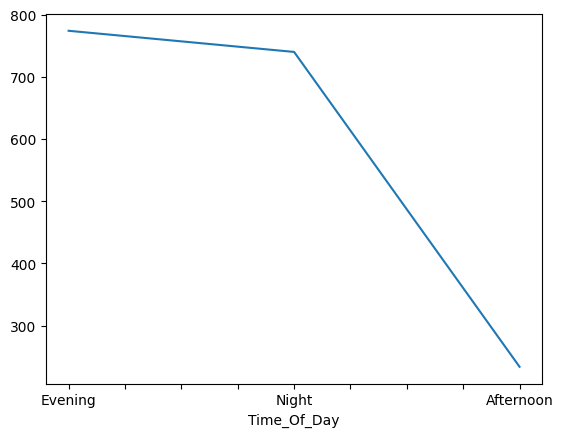

In [9]:
df["Time_Of_Day"] = df["Show_DateTime"].dt.hour.apply(time_of_day)
time_counts = df["Time_Of_Day"].value_counts()
time_counts.plot()
plt.show()

### crowd_Size vs Time_of_Day realtion

the **narrators hyposthesis** is expected for train is **acccepted** by visulisation  and shows hisher crowd size at evening and night than Afternoon significantly

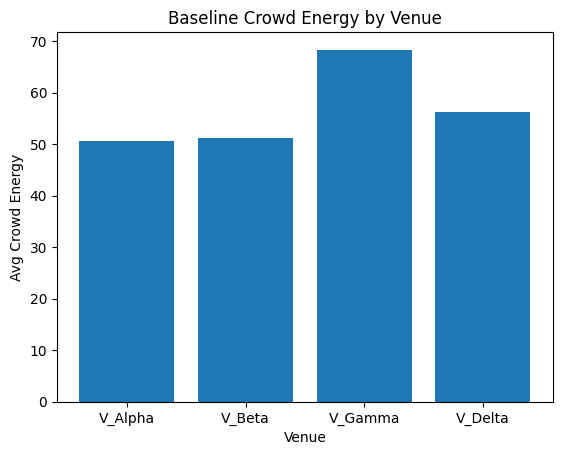

In [10]:
baseline_energy = {
    "V_Alpha": Alpha["Crowd_Energy"].mean(),
    "V_Beta":  Beta["Crowd_Energy"].mean(),
    "V_Gamma": Gamma["Crowd_Energy"].mean(),
    "V_Delta": Delta["Crowd_Energy"].mean(),
}

plt.bar(baseline_energy.keys(), baseline_energy.values())
plt.xlabel("Venue")
plt.ylabel("Avg Crowd Energy")
plt.title("Baseline Crowd Energy by Venue")
plt.show()


### Baseline energy vs Venue 
(V_Gamma: Venue) shws specific crowd energy significantly more value than mean global crowd energy 

